# 自动微分

正如 [微积分](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/01.preliminaries/calculus.ipynb) 中所说，求导是几乎所有深度学习优化算法的关键步骤。
虽然求导的计算很简单，只需要一些基本的微积分。
但对于复杂的模型，手工进行更新是一件很痛苦的事情（而且经常容易出错）。

深度学习框架通过自动计算导数，即*自动微分*（automatic differentiation）来加快求导。
实际中，根据设计好的模型，系统会构建一个*计算图*（computational graph），
来跟踪计算是哪些数据通过哪些操作组合起来产生输出。
自动微分使系统能够随后反向传播梯度。
这里，*反向传播*（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

## 一个简单的例子

作为一个演示例子，(**假设我们想对函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于列向量$\mathbf{x}$求导**)。
首先，我们创建变量`x`并为其分配一个初始值。

In [1]:
import torch

x = torch.arange(4.0)
x, x.shape

(tensor([0., 1., 2., 3.]), torch.Size([4]))

**单个向量默认方向是列向量**

[**在我们计算$y$关于$\mathbf{x}$的梯度之前，需要一个地方来存储梯度。**]
重要的是，我们不会在每次对一个参数求导时都分配新的内存。
因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。
注意，一个标量函数关于向量$\mathbf{x}$的梯度是向量，并且与$\mathbf{x}$具有相同的形状。

In [2]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0, requires_grad=True)
print(x.grad)  # 默认值是None

None


(**现在计算$y$。**)

In [3]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

`x`是一个长度为4的向量，计算`x`和`x`的点积，得到了我们赋值给`y`的标量输出。
接下来，[**通过调用反向传播函数来自动计算`y`关于`x`每个分量的梯度**]，并打印这些梯度。

In [4]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于$\mathbf{x}$的梯度应为$4\mathbf{x}$。
让我们快速验证这个梯度是否计算正确。

In [5]:
x.grad == 4 * x

tensor([True, True, True, True])

[**现在计算`x`的另一个函数。**]

In [6]:
# 在默认情况下，Pytorch会累积梯度，我需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

多loss的情况，梯度要累加

## 非标量变量的反向传播

当`y`不是标量时，向量`y`关于向量`x`的导数的最自然解释是一个矩阵。
对于高阶和高维的`y`和`x`，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括[**深度学习中**]），
但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。
这里(**，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。**)

In [7]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
print(y)
print(torch.ones(len(x)))
# 等价于y.backward(torch.ones(len(x)))
print(y.sum())
y.sum().backward()
x.grad

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
tensor([1., 1., 1., 1.])
tensor(14., grad_fn=<SumBackward0>)


tensor([0., 2., 4., 6.])

## 分离计算

有时，我们希望[**将某些计算移动到记录的计算图之外**]。
例如，假设`y`是作为`x`的函数计算的，而`z`则是作为`y`和`x`的函数计算的。
想象一下，我们想计算`z`关于`x`的梯度，但由于某种原因，希望将`y`视为一个常数，
并且只考虑到`x`在`y`被计算后发挥的作用。

这里可以分离`y`来返回一个新变量`u`，该变量与`y`具有相同的值，
但丢弃计算图中如何计算`y`的任何信息。
换句话说，梯度不会向后流经`u`到`x`。
因此，下面的反向传播函数计算`z=u*x`关于`x`的偏导数，同时将`u`作为常数处理，
而不是`z=x*x*x`关于`x`的偏导数。

In [8]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

**detach()在做将网络中参数固定住是很有用的功能**

由于记录了`y`的计算结果，我们可以随后在`y`上调用反向传播，
得到`y=x*x`关于的`x`的导数，即`2*x`。

In [9]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Python控制流的梯度计算

使用自动微分的一个好处是：
[**即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度**]。
在下面的代码中，`while`循环的迭代次数和`if`语句的结果都取决于输入`a`的值。

其中norm()函数用来求$L_2$范数

In [10]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

让我们计算梯度

In [11]:
a = torch.randn(size=(), requires_grad=True)
print(a)
d = f(a)
print(d)
d.backward()

tensor(-0.2734, requires_grad=True)
tensor(-111988.7578, grad_fn=<MulBackward0>)


我们现在可以分析上面定义的`f`函数。
请注意，它在其输入`a`中是分段线性的。
换言之，对于任何`a`，存在某个常量标量`k`，使得`f(a)=k*a`，其中`k`的值取决于输入`a`，因此可以用`d/a`验证梯度是否正确。

In [12]:
a.grad == d / a

tensor(True)

## 小结

* 深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。
* 深度学习中需要对每一层计算梯度，如果用正向累积（从叶子到根）计算每一个变量的梯度都需要重新扫一遍，这个计算复杂度太高；而反向累积扫一遍就可以得到每个变量的梯度（因为保存了中间结果）
* 在深度学习中不做向量、矩阵的求导，只做标量的求导
* Pytorch隐式构造对控制流做的更好一点，但是会相对显式构造慢一些

## 练习

1. 为什么计算二阶导数比一阶导数的开销要更大？
1. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。
1. 在控制流的例子中，我们计算`d`关于`a`的导数，如果将变量`a`更改为随机向量或矩阵，会发生什么？
1. 重新设计一个求控制流梯度的例子，运行并分析结果。
1. 使$f(x)=\sin(x)$，绘制$f(x)$和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x)=\cos(x)$。

### 练习题一

在PyTorch中计算一阶导数和二阶导数都是通过自动微分机制实现的，下面解释一下为什么计算二阶导数的开销通常要比计算一阶导数要大：

1. 计算图的构建：在计算一阶导数时，PyTorch只需要构建一次计算图，然后根据需要进行反向传播即可。而在计算二阶导数时，需要构建两次计算图，第一次是计算一阶导数，第二次是计算一阶导数的导数，也就是二阶导数。因此，计算二阶导数需要更多的计算图构建操作。

1. 内存占用：计算一节导数时，PyTorch只需要保留一节导数的梯度值，而计算二阶导数时需要保留一阶导数和二阶导数的梯度值，这会占用更多的内存。

1. 计算量增加：计算二阶导数需要对一阶导数进行额外的计算，这增加了计算量和计算时间。

因此，计算二阶导数的开销通常要比计算一阶导数更大。

### 练习题二

In [1]:
import torch

x = torch.arange(4.0, requires_grad=True)
print(x)
y = torch.dot(x, x).sqrt()
print(y)
y.backward()
print(x.grad)

try:
    y.backward()
    print(x.grad)
except Exception as e:
    print(e)

tensor([0., 1., 2., 3.], requires_grad=True)
tensor(3.7417, grad_fn=<SqrtBackward0>)
tensor([0.0000, 0.2673, 0.5345, 0.8018])
Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


如果需要第二次执行反向传播，或者在反向传播调用后需要访问保存的张量，请指定retain_graph=True。

In [2]:
x = torch.arange(4.0, requires_grad=True)
print(x)
y = torch.dot(x, x).sqrt()
print(y)
y.backward(retain_graph=True)
print(x.grad)

try:
    y.backward()
    print(x.grad)
except Exception as e:
    print(e)

tensor([0., 1., 2., 3.], requires_grad=True)
tensor(3.7417, grad_fn=<SqrtBackward0>)
tensor([0.0000, 0.2673, 0.5345, 0.8018])
tensor([0.0000, 0.5345, 1.0690, 1.6036])


### 练习题三

In [3]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c
a = torch.randn(size=(1, 3), requires_grad=True)
print(a)
d = f(a)

try:
    d.backward()
except Exception as e:
    print(e)

tensor([[-0.0900, -0.2434,  0.4254]], requires_grad=True)
grad can be implicitly created only for scalar outputs


根据上述执行结果，如果将变量 $a$ 更改为随机向量或矩阵，会报错，因为PyTorch只能对标量结果求梯度，可以将代码进行以下修改：

In [4]:
try:
    print(torch.ones_like(d))
    d.backward(torch.ones_like(d))
except Exception as e:
    print(e)
print(a.grad)

tensor([[1., 1., 1.]])
tensor([[2048., 2048., 2048.]])


### 练习题四

In [5]:
def f(a):
    b = a * 2
    while b.norm(1) < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c.sum()
a = torch.randn(size=(), requires_grad=True)
d = f(a)
print(a)
d.backward()
print(a.grad)
a.grad == d / a

tensor(-0.2580, requires_grad=True)
tensor(409600.)


tensor(True)

### 练习题五

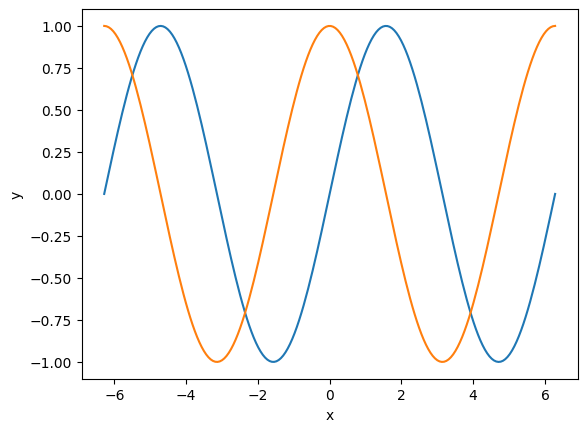

In [7]:
import matplotlib.pyplot as plt

def f(x):
    return torch.sin(x)


def df(x):
    x.requires_grad_()
    y = f(x)
    y.backward(torch.ones_like(y))
    return x.grad

x = torch.linspace(-2*torch.pi, 2*torch.pi, 200)

y1 = f(x)
y2 = df(x)

plt.plot(x.detach().numpy(), y1.detach().numpy(), label='f(x)=sin(x)')
plt.plot(x.detach().numpy(), y2.detach().numpy(), label='df(x)/dx')
# plt.legend() # 使上述代码产生效果
plt.xlabel('x')
plt.ylabel('y')
plt.show()

tensor在计算图里了，想要把tensor转为numpy就要把tensor从计算图中脱离出来（detach），如果不脱离会报错的[Tensor.detach()解释](https://blog.csdn.net/m0_47746932/article/details/119598396)